### Mooring Report, Lake Zug, 2026.01.14

In [1]:
# imports
import ewgreaders as ewg
import pylake
import os
from glob import glob
import json
import xarray as xr
import numpy as np
import pandas as pd
import scipy
import dolfyn as dlfn
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

c:\Users\herremha\AppData\Local\anaconda3\envs\ewg\Lib\site-packages\pylake\pylake.py:3: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
lake = 'Zugersee'
location = 'LZC'
year = '2026'
date = '20260114'

t_start = '2025-11-01'
t_end = '2026-01-13'

In [3]:
mreader = ewg.mooring_reader.MooringReader(lake, location, year, date)
adcps = mreader.get_adcps()
thermistors = mreader.get_thermistors()
oxygen_loggers = mreader.get_oxygen_loggers()

### ADCPs

In [4]:
adcps

[{'instrument': 'adcp', 'serial_id': '8315', 'mab': 123, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '672', 'mab': 98, 'comments': 'up'},
 {'instrument': 'adcp', 'serial_id': '1728', 'mab': 98, 'comments': 'down'},
 {'instrument': 'adcp', 'serial_id': '16549', 'mab': 41.4, 'comments': 'up'}]

In [5]:
all_adcp = []
for adcp in adcps:
    serial_id = adcp['serial_id']

    areader = ewg.adcp_reader.ADCPReader(serial_id, lake, location, year, date)
    fpath = areader.locate_data_file('L0')
    ds = areader.load_from_L0(fpath)
    ds = areader.range_to_depth(ds)
    ds = areader.run_qa(ds)
    print(areader.depth)
    ds = ds.sel(time=slice(t_start, t_end))
    all_adcp.append(ds)


Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\12U8315.000 ...
43.408226013183594

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U672.000 ...
71.59141540527344

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\6D1728.000 ...
80.0

Reading file Q:/Messdaten/Aphys_Hypothesis_data/Zugersee/2026/Mooring/20260114/LZC/L0\3U16549.000 ...
131.96441650390625


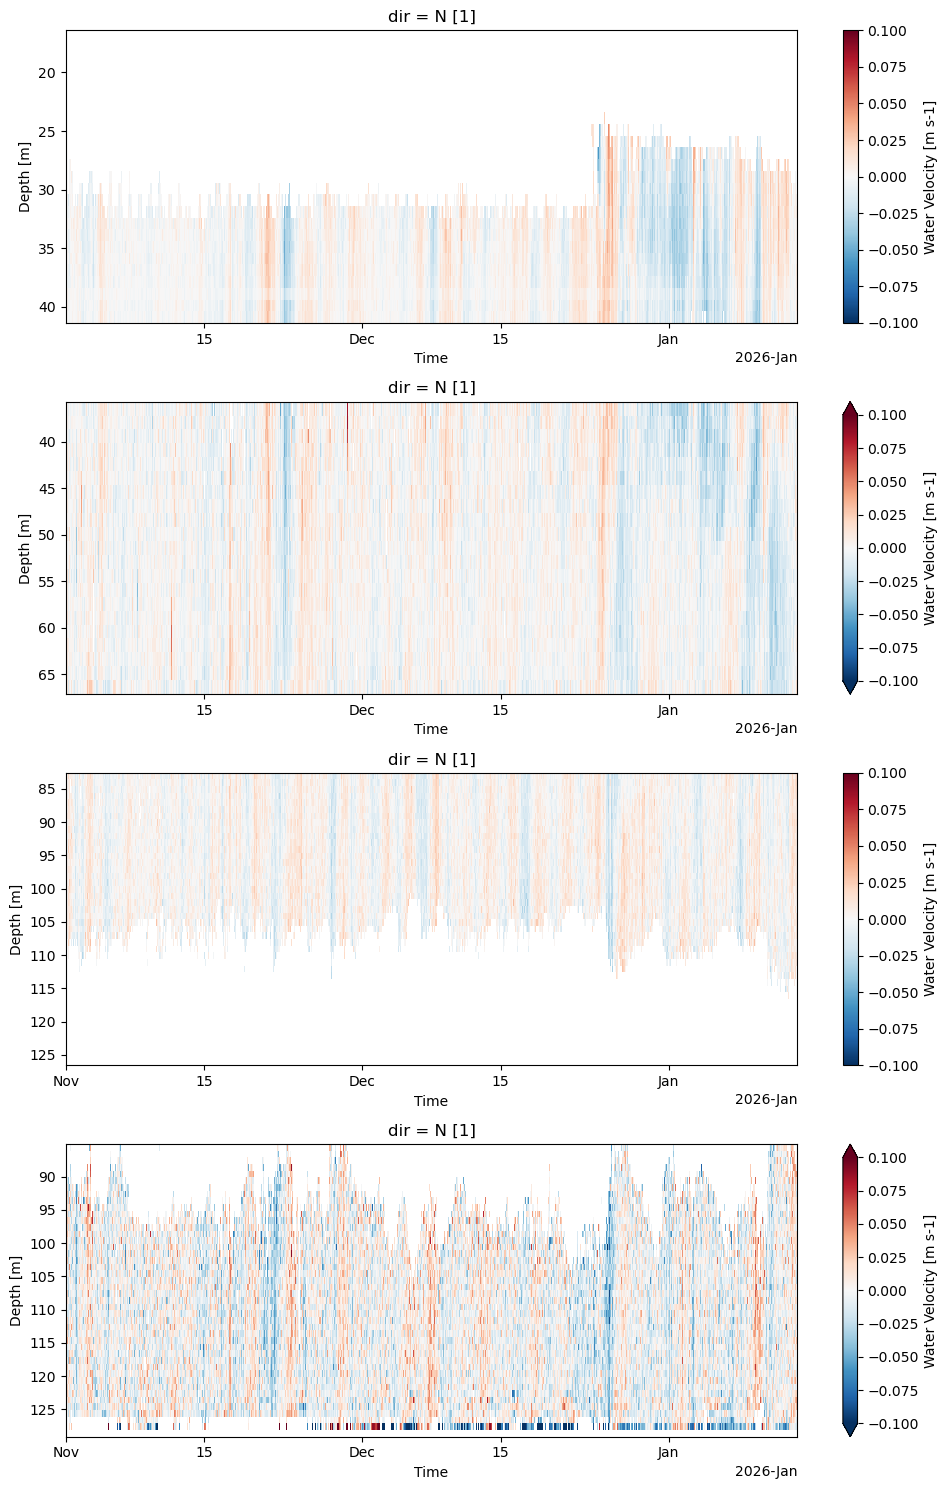

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))

for i, d in enumerate(all_adcp):
    d.vel.sel(dir='N').plot(cmap='RdBu_r', vmin=-0.1, vmax=0.1, ax=ax[i])

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('Depth [m]')

    ax[i].invert_yaxis()

plt.tight_layout()
plt.show()

### Oxygen Loggers

In [7]:
oxygen_loggers

[{'instrument': 'minidot', 'serial_id': '007431', 'mab': 70, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '893460', 'mab': 65, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '969903', 'mab': 60, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '899457', 'mab': 55, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '990558', 'mab': 50, 'comments': ''},
 {'instrument': 'minidot', 'serial_id': '867666', 'mab': 45, 'comments': ''}]

In [8]:
ds_chain = []
for ol in oxygen_loggers:
    serial_id = ol['serial_id']

    oreader = ewg.o2_reader.O2Reader(serial_id, lake, location, year, date)
    fpath = os.path.join(mreader.dpath_L0, f'7450-{serial_id}/Cat.txt')
    oreader.fpath = fpath
    oreader.sensor = oreader.get_sensor_type()
    oreader.mab = oreader.get_mab()
    oreader.depth = oreader.set_depth()

    ds = oreader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds['d_oxygen_conc'] *= (1000/32)    # conver to umol/L
    ds_chain.append(ds)

ds_do = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


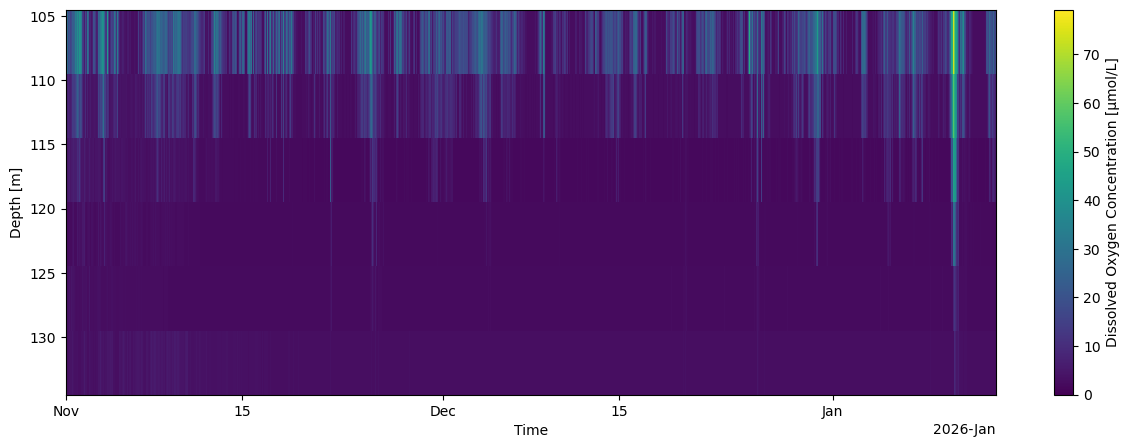

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_do.d_oxygen_conc.plot(cmap='viridis', vmin=0, ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Dissolved Oxygen Concentration [µmol/L]")

ax.invert_yaxis()
plt.show()

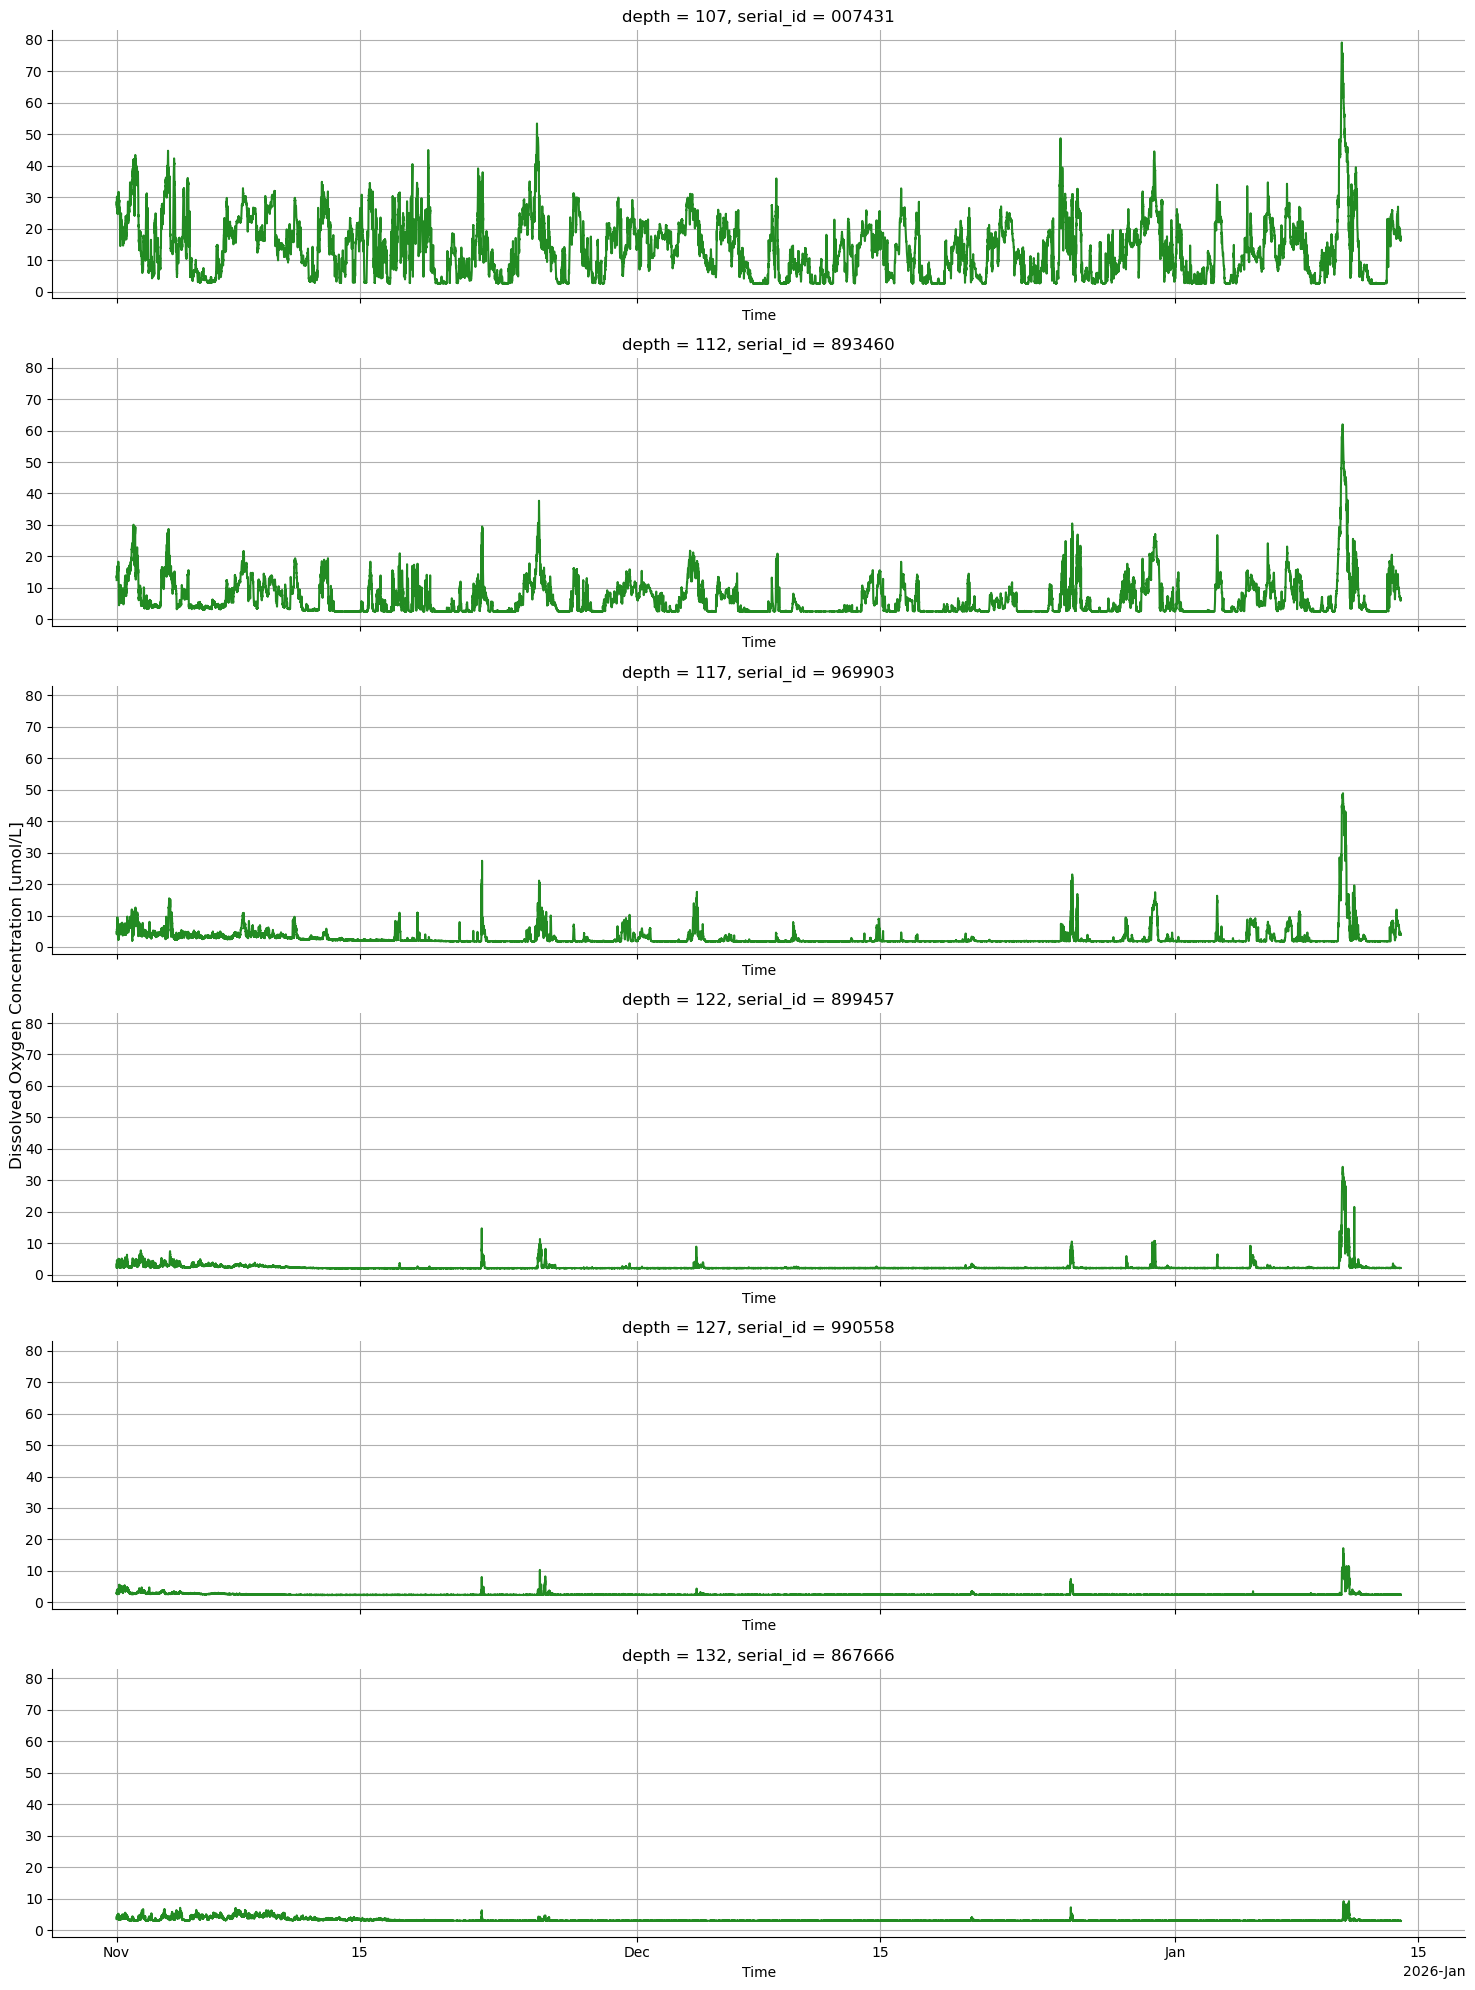

In [10]:
fig, ax = plt.subplots(nrows=6, ncols=1, figsize=(15, 20), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['d_oxygen_conc'].plot(color='forestgreen', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Dissolved Oxygen Concentration [umol/L]')
plt.tight_layout()
plt.show()

### Thermistors

In [11]:
thermistors

[{'instrument': 'rbr_temp', 'serial_id': '200570', 'mab': 120, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200569', 'mab': 115, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205523', 'mab': 110, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205517', 'mab': 105, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205518', 'mab': 100, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205535', 'mab': 95, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205527', 'mab': 90, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '209296', 'mab': 85, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205521', 'mab': 80, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200567', 'mab': 75, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '205536', 'mab': 70, 'comments': ''},
 {'instrument': 'rbr_temp', 'serial_id': '200575', 'mab': 65, 'comments': ''},
 {'instrument': 'rbr_temp',
  'serial_id': '209

In [12]:
ds_chain = []
for t in thermistors:
    serial_id = t['serial_id']

    treader = ewg.thermistor_reader.ThermistorReader(serial_id, lake, location, year, date)
    ds = treader.load_from_L0()
    ds = ds.sel(time=slice(t_start, t_end))
    ds_chain.append(ds)

ds_temp = mreader.create_instrument_chain(ds_chain)

C:\Users\herremha\elcres\ewgreaders\ewgreaders\readers\mooring_reader.py:243: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  return xr.concat(ds_aligned, dim='depth')


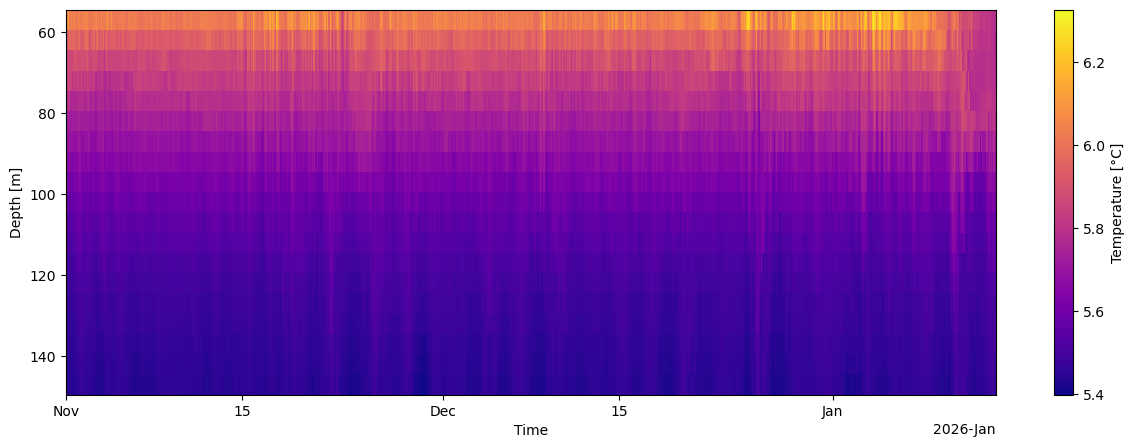

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))
im = ds_temp.temp.plot(cmap='plasma', ax=ax)

ax.set_xlabel("Time")
ax.set_ylabel('Depth [m]')
im.colorbar.set_label("Temperature [°C]")

ax.invert_yaxis()
plt.show()

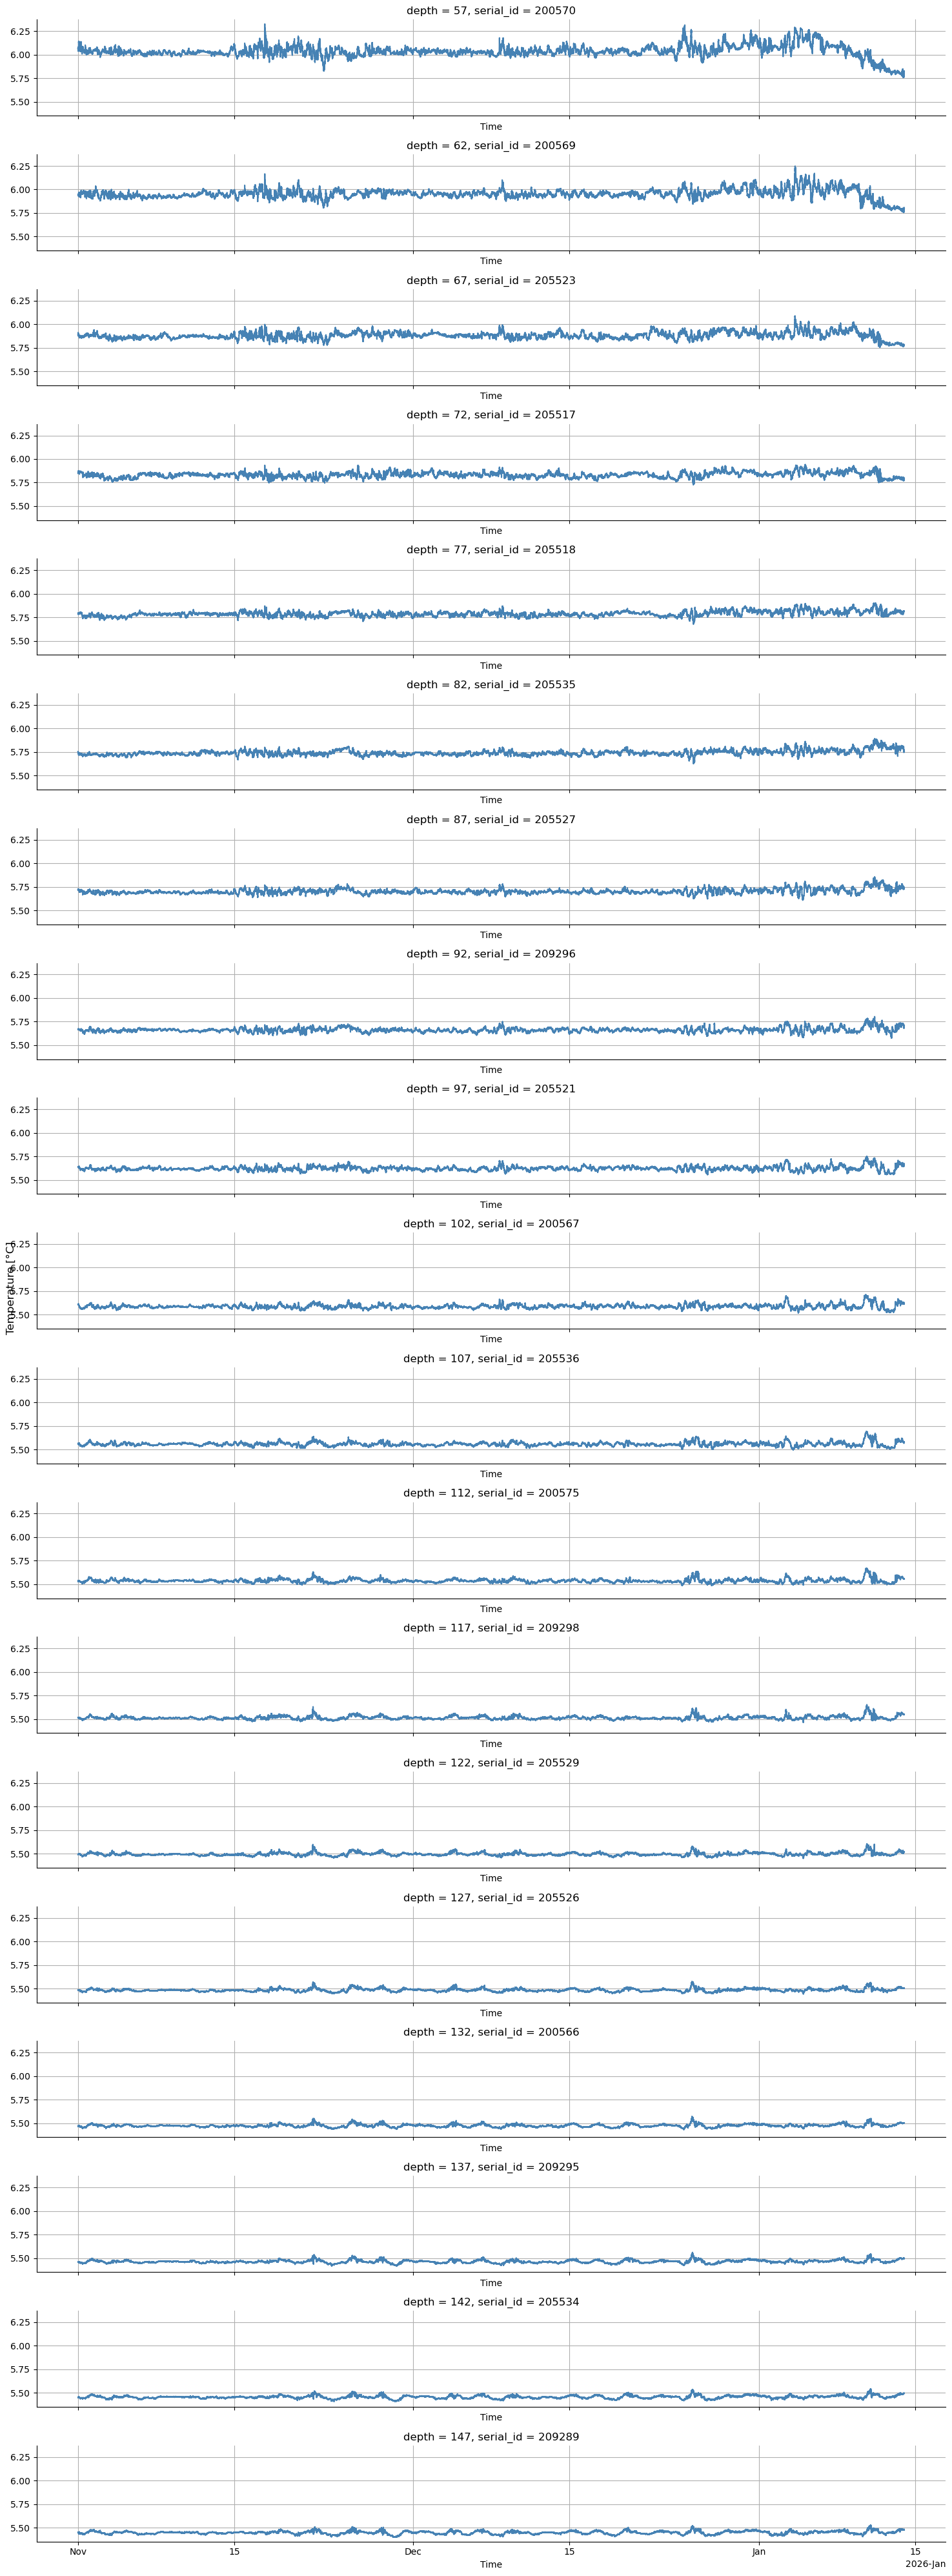

In [14]:
fig, ax = plt.subplots(nrows=len(thermistors), ncols=1, figsize=(15, 40), sharex=True, sharey=True)

for i, d in enumerate(ds_chain):
    d['temp'].plot(color='steelblue', ax=ax[i])
    #ax[i].axhline(0, color='black', ls='--')

    ax[i].set_xlabel('Time')
    ax[i].set_ylabel('')

    ax[i].grid(True)
    ax[i].spines[['right', 'top']].set_visible(False)

fig.supylabel('Temperature [°C]')
plt.tight_layout()
plt.show()

### Flux and net transport

In [27]:
mxsc, mysc =  mreader.get_swiss_coords()
bathy = xr.open_dataset(mreader.BATHY_PATH.format(lake=lake))

In [66]:
ds = all_adcp[0]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.calculate_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [67]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
time_s = (ds_flux.time - ds_flux.time[0]).astype('timedelta64[s]').astype(float)
transport = ds_flux.assign_coords(time=time_s).fillna(0).integrate('time')

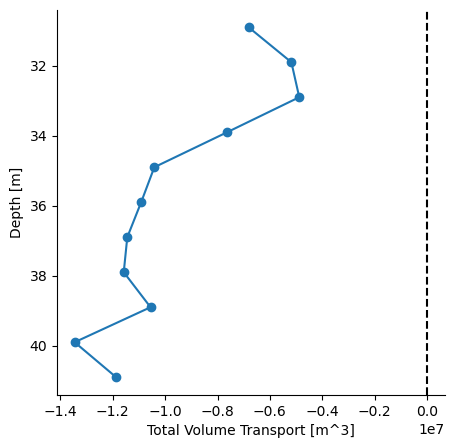

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [69]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

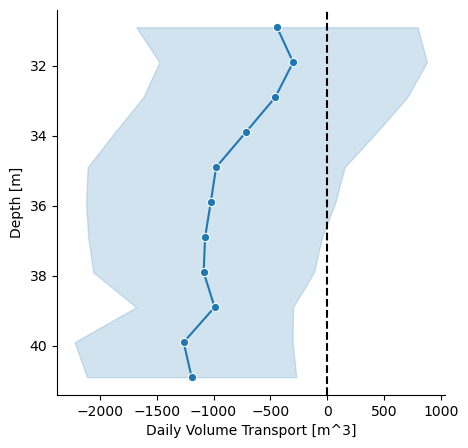

In [70]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

ax.set_xlabel('Daily Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [71]:
ds = all_adcp[1]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.calculate_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [72]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
time_s = (ds_flux.time - ds_flux.time[0]).astype('timedelta64[s]').astype(float)
transport = ds_flux.assign_coords(time=time_s).fillna(0).integrate('time')

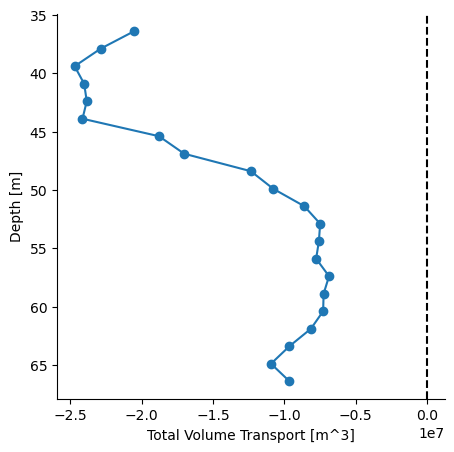

In [73]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [74]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

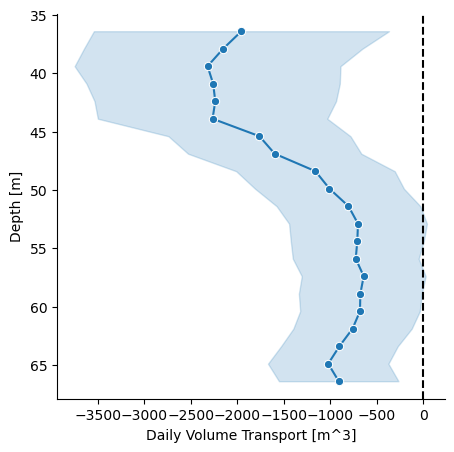

In [75]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

ax.set_xlabel('Daily Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [76]:
ds = all_adcp[2]

flux_data = []
for d in ds.range.values:
    flux = ewg.lakes.calculate_flux(ds, d, mxsc, mysc, 0, bathy)
    flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [77]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
time_s = (ds_flux.time - ds_flux.time[0]).astype('timedelta64[s]').astype(float)
transport = ds_flux.assign_coords(time=time_s).fillna(0).integrate('time')

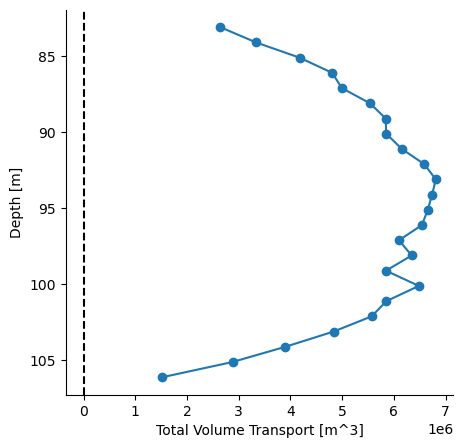

In [78]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [79]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

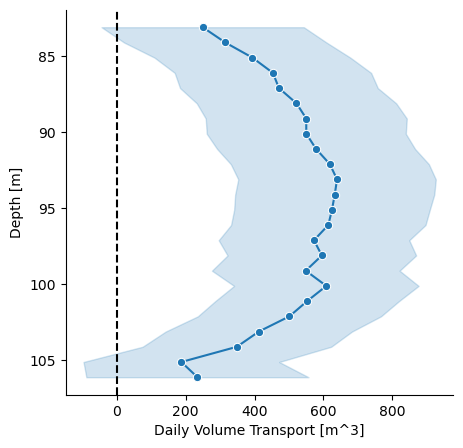

In [80]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

ax.set_xlabel('Daily Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

In [81]:
ds = all_adcp[3]

flux_data = []
for d in ds.range.values:
    if d < 126:
        flux = ewg.lakes.calculate_flux(ds, d, mxsc, mysc, 0, bathy)
        flux_data.append(flux)

ds_flux = xr.concat(flux_data, dim='range')

In [ ]:
# require 50% data validity
thresh = 0.5
valid_depths = ds_flux.notnull().mean(dim='time')
ds_flux = ds_flux.sel(range=valid_depths >= thresh)

# calculate net transport
time_s = (ds_flux.time - ds_flux.time[0]).astype('timedelta64[s]').astype(float)
transport = ds_flux.assign_coords(time=time_s).fillna(0).integrate('time')

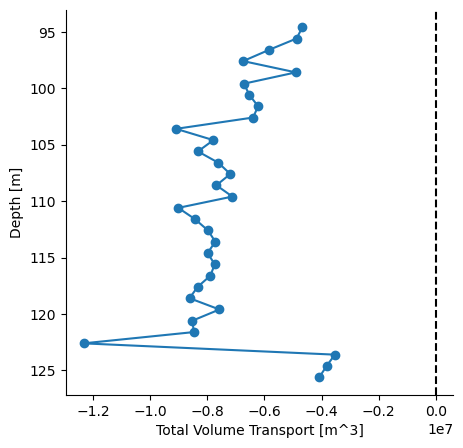

In [83]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
ax.plot(transport.values, transport.range, marker='o')

ax.set_xlabel('Total Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)

plt.show()

In [88]:
dt = 600
# daily average
df = ds_flux.to_dataframe().reset_index()
df['flux'] = df['flux'] * dt
df['day'] = df['time'].dt.floor('D')
df_avg = df.groupby(['day', 'range'])['flux'].mean().reset_index()

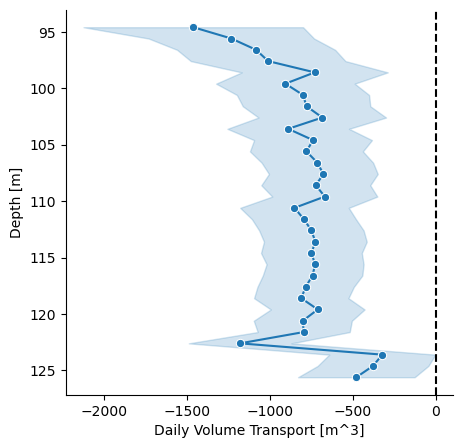

In [89]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.axvline(0, color='black', linestyle='--')
sns.lineplot(df_avg, x='flux', y='range', orient='y', marker='o', errorbar=('se', 1), err_style='band', ax=ax)

ax.set_xlabel('Daily Volume Transport [m^3]')
ax.set_ylabel('Depth [m]')

ax.invert_yaxis()
ax.spines[['right', 'top']].set_visible(False)
plt.show()

### Direction of maximal flow

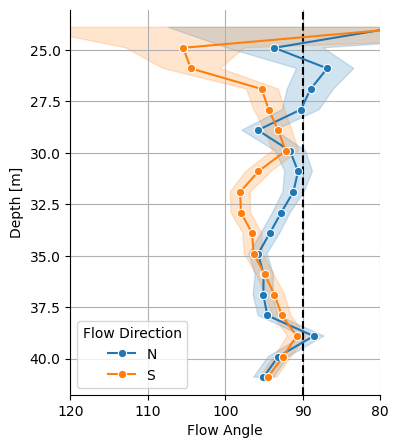

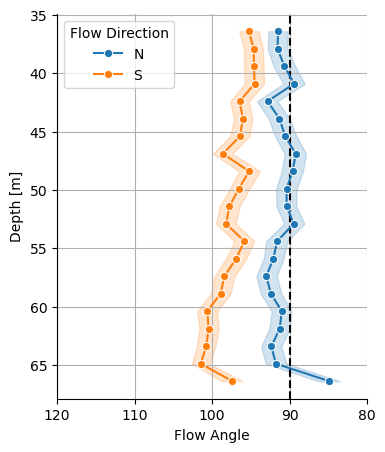

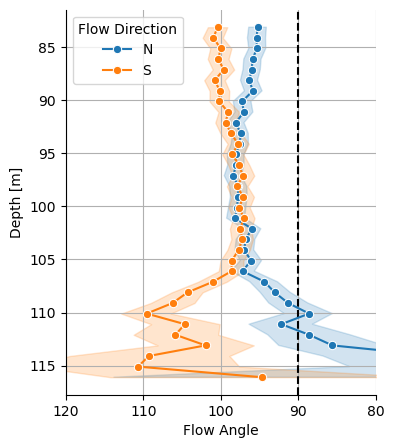

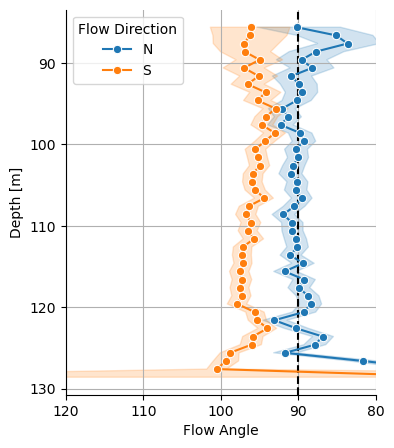

In [94]:
flow_angle_data = []
for ds in all_adcp:
    flow_angle = ewg.lakes.calculate_flow_angle(ds)
    flow_angle_data.append(flow_angle)

    df_angle = flow_angle.to_dataframe().reset_index().dropna()
    df_angle['angle_shifted'] = [a - 180 if a >= 180 else a for a in df_angle['angle']]
    df_angle['dir'] = ['N' if a < 180 else 'S' for a in df_angle['angle']]

    fig, ax = plt.subplots(figsize=(4, 5))

    ax.axvline(90, color='black', linestyle='--')
    sns.lineplot(df_angle, x='angle_shifted', y='range', orient='y', hue='dir', hue_order=['N', 'S'], marker='o', ax=ax)

    ax.set_xlabel('Flow Angle')
    ax.set_ylabel('Depth [m]')

    ax.set_xlim(80, 120)
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.spines[['right', 'top']].set_visible(False)
    ax.grid(True)

    ax.legend(title='Flow Direction')

    plt.show()

### Excursion length

In [ ]:
v = ds.vel.sel(dir='N').sel(range=120, method='nearest')

In [ ]:
data = []
i = 0
while i < len(v):
    # Southward excursion
    if v[i] < 0:
        j = i

        # contiguous S-ward motion
        while j < len(v) and v[j] < 0:
            j += 1
        
        # only excusions greater than a single measurement
        if j > i+1:
            v_sel = v.isel(time=slice(i, j))
            time_s = (v_sel.time - v_sel.time[0]).astype('timedelta64[s]').astype(float)
            duration = time_s.max().item() - time_s.min().item()

            # excursion length
            el = v_sel.assign_coords(time=time_s).integrate('time').item()
            
            data.append({
                'direction': 'S',
                't_start': v_sel.time[0].item(),
                't_end': v_sel.time[-1].item(),
                'duration_s':  duration,
                'excursion_length': el
            })

        i = j
    else:
        i += 1

data = pd.DataFrame(data)